In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from numpy.linalg import svd
import kagglehub

# Visualizing Dyad

### Load and SVD of the "camera" image from skimage library

Image shape:  (512, 512)


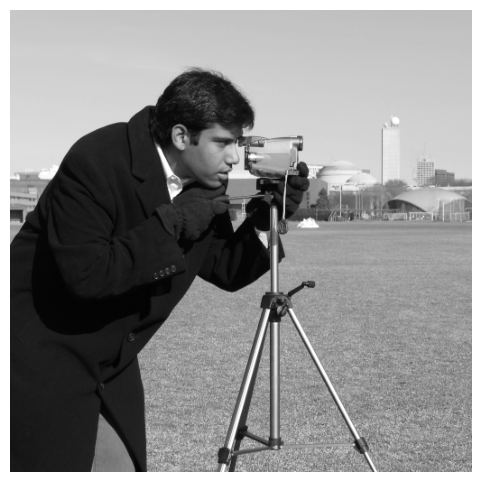

In [11]:
# 1.1 Load the gray-scale image and SVD decomposition
image = skimage.data.camera()
m, n = image.shape
print("Image shape: ", image.shape)

U, S, Vt = svd(image, full_matrices=False)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

### Visualize some of the dyad of the decomposition

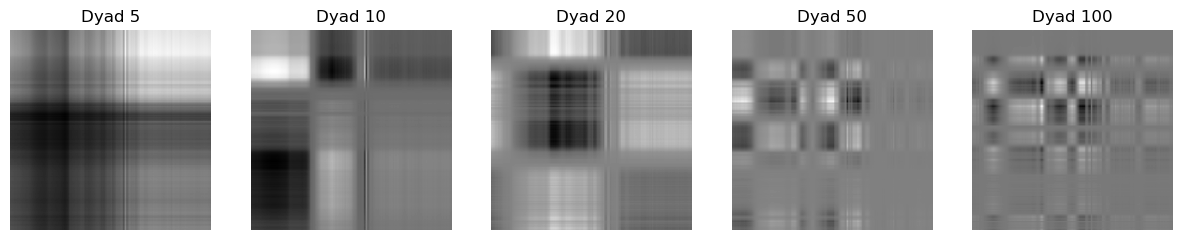

In [12]:
# Some chosen ranks for the dyads
dyad_indices = [4, 9, 19, 49, 99]
dyads = []

plt.figure(figsize=(15, 5))

# 1.2 Display the chosen dyads
for i, rank in enumerate(dyad_indices):
    dyad = S[i] * np.outer(U[:, i], Vt[i, :])
    dyads.append(dyad)
    
    plt.subplot(1, len(dyad_indices), i + 1)
    plt.imshow(dyad, cmap='gray')
    plt.title(f"Dyad {rank+1}")
    plt.axis('off')

plt.show()

The results obtained by calculating the dyads of an image represent individual rank-1 approximations extracted from the SVD of the image, these selected dyads provide a breakdown of the image structure, where lower-rank dyads capture dominant features, while higher-rank dyads represent finer details of the image.

### Plot of the singular values of X

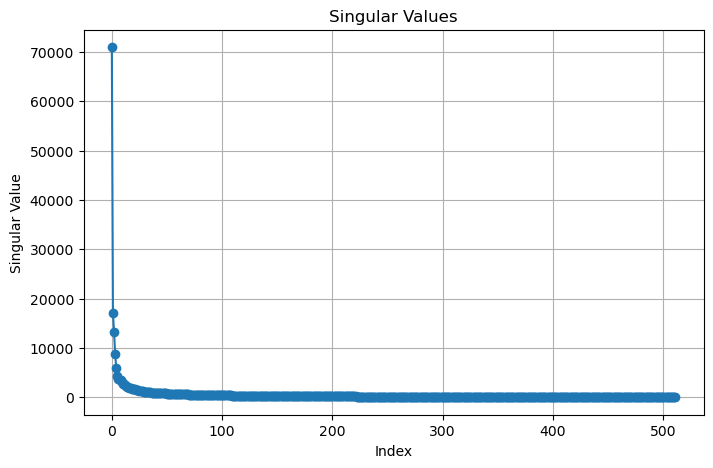

In [13]:
# 1.3 Plot the singular values
plt.figure(figsize=(8, 5))
plt.plot(S, marker='o')
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid()
plt.show()

The singular values decrease rapidly, indicating that most of the image's information is contained in the first few singular values.

### Visualise the k-rank approximation

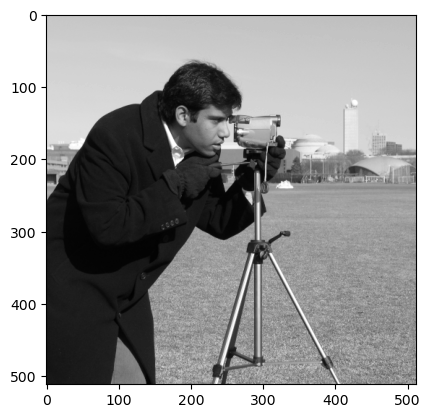

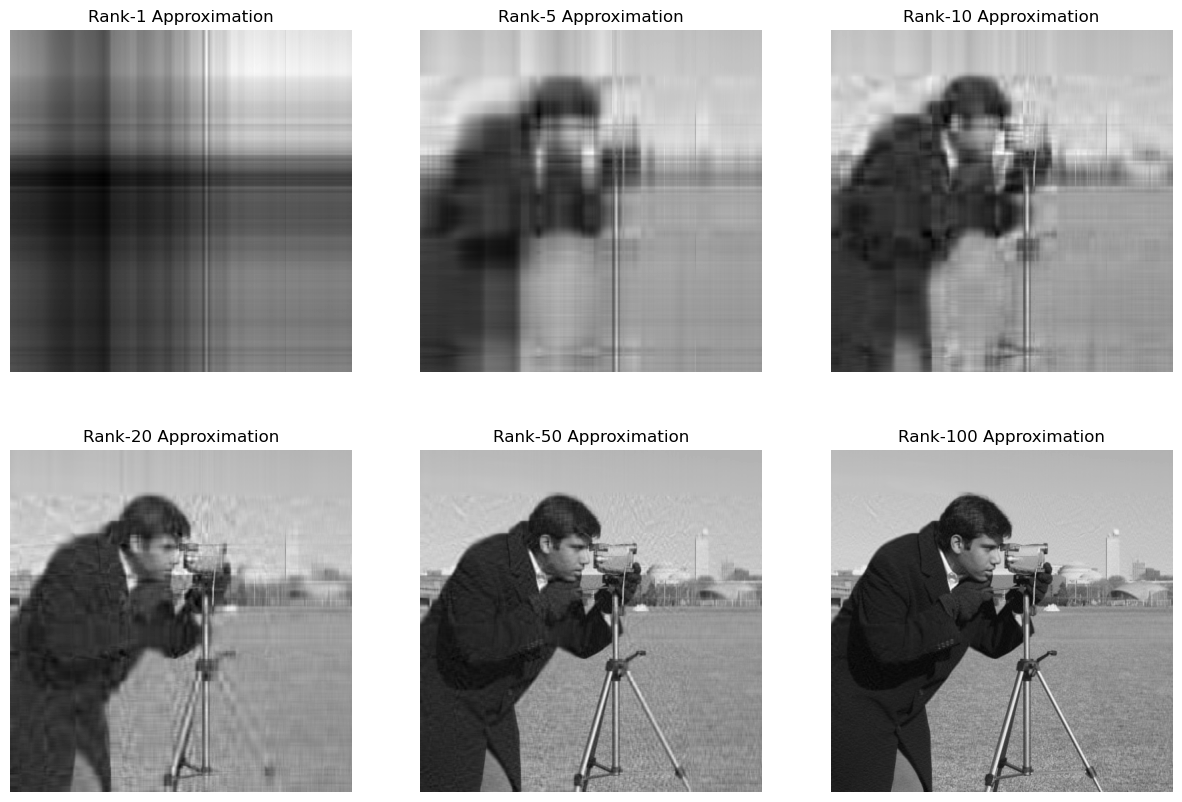

In [14]:
# Print the original image
plt.imshow(image, cmap='gray')

# 1.4 Visualize the rank-k approximations
ks = [1, 5, 10, 20, 50, 100]
plt.figure(figsize=(15, 10))
for i, k in enumerate(ks):
    X_k = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    plt.subplot(2, len(ks)//2, i + 1)
    plt.imshow(X_k, cmap='gray')
    plt.title(f"Rank-{k} Approximation")
    plt.axis('off')
plt.show()

Low-rank approximations capture the overall structure of the initial image, as 𝑘 increases, the reconstruction quality increasingly noticebly, indeed with k=100 (less than one-fifth of the original data) the image is hardly distinguishable from the original.

### Compute Approximation Error

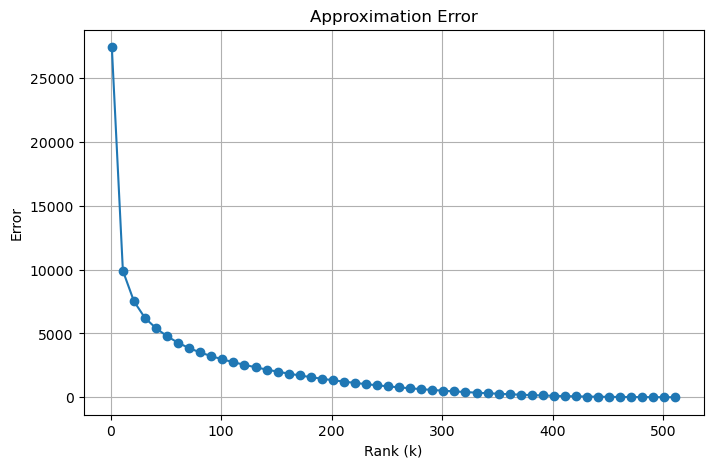

In [15]:
def compute_approximation_error(U, S, Vt, k_values, original_image):
    errors = []
    for k in k_values:
        X_k = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
        error = np.linalg.norm(original_image - X_k, 'fro')
        errors.append(error)
    return errors

# 1.5 Computation and plot of the approximation error
k_values = np.arange(1, n+1, 10)
errors = compute_approximation_error(U, S, Vt, k_values, image)

plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o')
plt.title("Approximation Error")
plt.xlabel("Rank (k)")
plt.ylabel("Error")
plt.grid()
plt.show()

### Plot of the compression factor

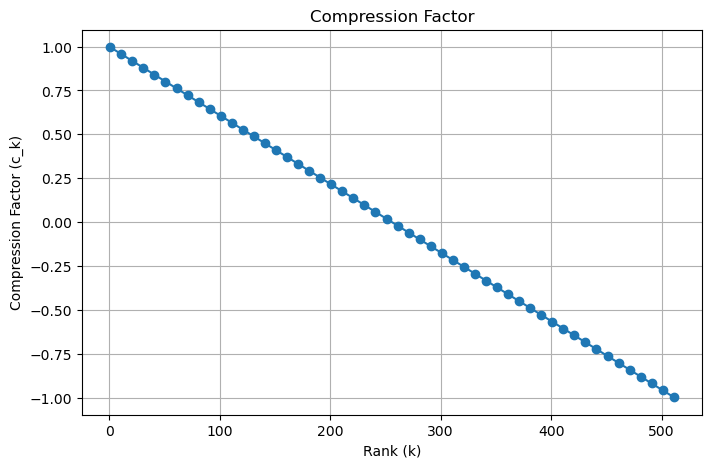

In [16]:
# 1.6 Computation and plot of the compression factor
compression_factors = [1 - (k * (m + n + 1) / (m * n)) for k in k_values]

plt.figure(figsize=(8, 5))
plt.plot(k_values, compression_factors, marker='o')
plt.title("Compression Factor")
plt.xlabel("Rank (k)")
plt.ylabel("Compression Factor (c_k)")
plt.grid()
plt.show()

The compression formula calculates the ratio of memory required for the U, V, and S matrices, given by $k \cdot (m+n+1)$, to the original image size $m\times n$, there is a threshold beyond which the approximation no longer compresses the image effectively, and storing it requires more space than the original image.

### Computation of k-value such that $c_k = 0$

In [17]:
k_c_zero = int((m * n) / (m + n + 1))
approximation_error_at_k_c_zero = compute_approximation_error(U, S, Vt, [k_c_zero], image)[0]

# Calculating the relative error for this approximation
X_k_c_zero = np.dot(U[:, :k_c_zero], np.dot(np.diag(S[:k_c_zero]), Vt[:k_c_zero, :]))
relative_error = np.linalg.norm(image-X_k_c_zero, 'fro') / np.linalg.norm(image, 'fro')

print(f"Zero compression factor rank: {k_c_zero} with error: {approximation_error_at_k_c_zero}, relative error: {relative_error}")

Zero compression factor rank: 255 with error: 818.4417220544295, relative error: 0.010757614051817077


The value $k=255$ ensures no compression, meaning the rank-255 approximation stores as much information as the original uncompressed image, for this $𝑘$, the approximation error is very low (818.44) with a relative error of 0.010, demonstrating that the SVD reconstruction is nearly identical to the original image.

# Classification of MNIST Digits with SVD Decomposition

In [18]:
# 1.1 Download and import latest version of the dataset
path = kagglehub.dataset_download("animatronbot/mnist-digit-recognizer")
data = pd.read_csv(path+"\\train.csv")

# Convert data into a matrix, then split it into X (image pixels) and Y (number labels)
data = np.array(data)

X = data[:, 1:]
X = X.T

Y = data[:, 0]

d, N = X.shape

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (784, 42000)
Y shape:  (42000,)


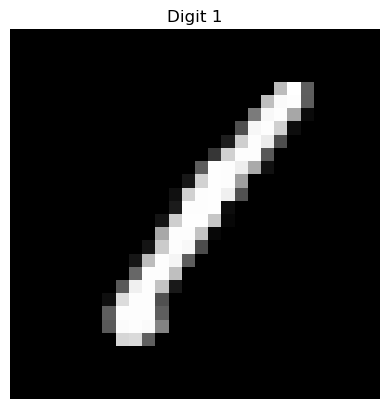

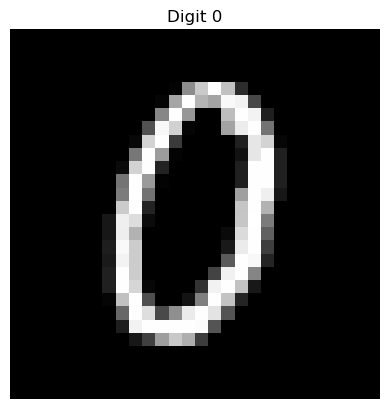

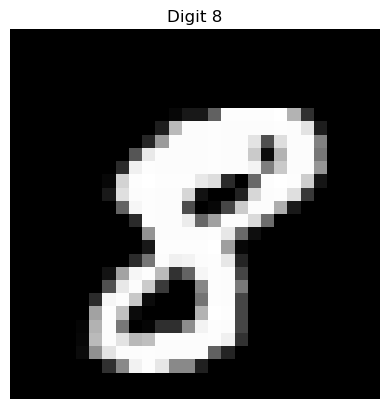

In [19]:
# 1.2 Visualization of a digit
def print_digit(id):
    plt.imshow(X[:, id].reshape(28, 28), cmap='gray')
    plt.title(f"Digit {Y[id]}".format(Y[id]))
    plt.axis('off')
    plt.show()
    
print_digit(0)
print_digit(5)
print_digit(10)

### Data Preparation

In [20]:
# 1.3 Filter just the digits 3 and 4
X_34 = X[:, (Y == 3) | (Y == 4)]
Y_34 = Y[(Y == 3) | (Y == 4)]

# 1.4 Randomly split the data into training and test sets
np.random.seed(42)
indices = np.random.permutation(X_34.shape[1])
split = int(0.8 * X_34.shape[1])

X_train = X_34[:, indices[:split]]
Y_train = Y_34[indices[:split]]

X_test = X_34[:, indices[split:]]
Y_test = Y_34[indices[split:]]

# 1.5 Divide the training set into two sets, each containing only one digit
X1_train = X_train[:, Y_train == 3]
X2_train = X_train[:, Y_train == 4]

### Setup of the model

Given the SVD decomposition of a matrix $X$ of size $d \times N$, we know that the $U$ matrix of size $d \times d$ contains an orthonormal basis of $p$ columns where $p=rank(X)$, given a $d$-dimensional vector $x$, it can be projected into $U$ as: $$x_{proj} = U(U^Tx)$$
In this exercise we are going to have an SVD decomposition for each class of elements, then, a classification will be made by evaluating which class projection will be closer to the new element:
$$\| x - x_{proj} \|_2 $$

In [21]:
# 1.6 Compute the SVD decomposition of X1 and X2
U1, S1, Vt1 = svd(X1_train, full_matrices=False)
U2, S2, Vt2 = svd(X2_train, full_matrices=False)

# 1.7 Classify a digit
def classify_digit(x, U1, U2, digit1, digit2):
    # Compute projections as x_perp = U @ U^T @ x
    x1_perp = U1 @ (U1.T @ x)
    x2_perp = U2 @ (U2.T @ x)
    
    # 1.8 Compute distances
    d1 = np.linalg.norm(x - x1_perp)
    d2 = np.linalg.norm(x - x2_perp)
    
    # Classify based on distances
    return digit1 if d1 < d2 else digit2

### Evaluation of the Model

The evaluation of the model will be made on the test set using misclassification rate defined as: $$ MR = \frac{1}{N_{\text{test}}} \sum_{i=1}^{N_{\text{test}}} g(f(x_i) == y_i), \text{where } g(True)=0, g(False)=1 $$

In [22]:
# 1.9 Evaluate the misclassification rate on the test set
predictions = np.array([classify_digit(X_test[:, i], U1, U2, 3, 4) for i in range(X_test.shape[1])])

misclassification_rate = np.mean(predictions != Y_test)

print("Misclassification rate:", misclassification_rate)

Misclassification rate: 0.23679525222551928


In [23]:
# 1.10 Repeat the experiment for other pairs of digits
def experiment_with_digits(digit1, digit2):
    indices = (Y == digit1) | (Y == digit2)
    X_filt = X[:, indices]
    Y_filt = Y[indices]
    
    np.random.seed(42)
    indices = np.random.permutation(X_filt.shape[1])
    split = int(0.8 * X_filt.shape[1])

    X_filt_train = X_filt[:, indices[:split]]
    Y_filt_train = Y_filt[indices[:split]]

    X_filt_test = X_filt[:, indices[split:]]
    Y_filt_test = Y_filt[indices[split:]]
    
    X1_filt_train = X_filt_train[:, Y_filt_train == digit1]
    X2_filt_train = X_filt_train[:, Y_filt_train == digit2]
        
    U1, S1, Vt1 = svd(X1_filt_train, full_matrices=False)
    U2, S2, Vt2 = svd(X2_filt_train, full_matrices=False)
    
    predictions = np.array([classify_digit(X_filt_test[:, i], U1, U2, digit1, digit2) for i in range(X_filt_test.shape[1])])
        
    misclassification_rate = np.mean(predictions != Y_filt_test)
    
    print(f"Digits {digit1} vs {digit2}: Misclassification rate = {misclassification_rate}")

experiment_with_digits(0, 1)
experiment_with_digits(3, 4)
experiment_with_digits(2, 3)
experiment_with_digits(5, 6)
experiment_with_digits(7, 8)
experiment_with_digits(1, 8)

Digits 0 vs 1: Misclassification rate = 0.003401360544217687
Digits 3 vs 4: Misclassification rate = 0.23679525222551928
Digits 2 vs 3: Misclassification rate = 0.05861664712778429
Digits 5 vs 6: Misclassification rate = 0.074354127284184
Digits 7 vs 8: Misclassification rate = 0.060838747784997045
Digits 1 vs 8: Misclassification rate = 0.148


 1.11 From the results we can see how different pairs have different misclassification rates, for example 1 and 0 have very low misclassification due to their distinct shapes, while others like 3 and 4 went worse due to shape similarity in the dataset

### Experimentation with Triplets of Digits

In [24]:
# 2.1 Classification function with 3 digits
def classify_digit_multi(x, U1, U2, U3, digit1, digit2, digit3):
    x1_perp = U1 @ (U1.T @ x)
    x2_perp = U2 @ (U2.T @ x)
    x3_perp = U3 @ (U3.T @ x)
    
    d1 = np.linalg.norm(x - x1_perp)
    d2 = np.linalg.norm(x - x2_perp)    
    d3 = np.linalg.norm(x - x3_perp)
    
    return digit1 if d1 < d2 and d1 < d3 else (digit2 if d2 < d3 else digit3)

def experiment_with_digits(digit1, digit2, digit3):
    indices = (Y == digit1) | (Y == digit2) | (Y == digit3)
    
    X_filt = X[:, indices]
    Y_filt = Y[indices]
    
    np.random.seed(42)
    indices = np.random.permutation(X_filt.shape[1])
    split = int(0.8 * X_filt.shape[1])

    X_filt_train = X_filt[:, indices[:split]]
    Y_filt_train = Y_filt[indices[:split]]

    X_filt_test = X_filt[:, indices[split:]]
    Y_filt_test = Y_filt[indices[split:]]

    # Compute SVD for each digit's submatrix
    X1_filt_train = X_filt_train[:, Y_filt_train == digit1]
    X2_filt_train = X_filt_train[:, Y_filt_train == digit2]
    X3_filt_train = X_filt_train[:, Y_filt_train == digit3]
    
    U1, S1, Vt1 = svd(X1_filt_train, full_matrices=False)
    U2, S2, Vt2 = svd(X2_filt_train, full_matrices=False)
    U3, S3, Vt3 = svd(X3_filt_train, full_matrices=False)
    
    # Classify test set and compute misclassification rate
    predictions = np.array([
        classify_digit_multi(X_filt_test[:, i], U1, U2, U3, digit1, digit2, digit3)
        for i in range(X_filt_test.shape[1])
    ])
    misclassification_rate = np.mean(predictions != Y_filt_test)
    
    print(f"Digits {digit1}, {digit2}, {digit3}: Misclassification rate = {misclassification_rate}")
    
experiment_with_digits(0, 1, 2)
experiment_with_digits(3, 4, 5)
experiment_with_digits(2, 3, 4)
experiment_with_digits(5, 6, 7)
experiment_with_digits(7, 8, 9)
experiment_with_digits(1, 8, 9)

Digits 0, 1, 2: Misclassification rate = 0.04501731435167372
Digits 3, 4, 5: Misclassification rate = 0.13338788870703763
Digits 2, 3, 4: Misclassification rate = 0.3531746031746032
Digits 5, 6, 7: Misclassification rate = 0.060802594244021076
Digits 7, 8, 9: Misclassification rate = 0.12880284472540499
Digits 1, 8, 9: Misclassification rate = 0.14882102821801313


By including a third digit, the projected distance is also calculated for this additional digit, and the final classification takes into account the information related to the U matrices of this new inclusion. 
From the results we observe that, on average, the misclassification rate slightly increased due to the choice of the addition.

# Clustering with PCA

In [25]:
# 1.1 Download and import latest version of the dataset
path = kagglehub.dataset_download("animatronbot/mnist-digit-recognizer")
data = pd.read_csv(path+"\\train.csv")

data = np.array(data)

X = data[:, 1:]
X = X.T

Y = data[:, 0]

# 1.2 Extraction of subset of data
n1, n2, n3 = 0, 6, 9
indices = (Y == n1) | (Y == n2) | (Y == n3)

X_filt = X[:, indices]
Y_filt = Y[indices]

# 1.3 Shuffle and split into training and test sets
np.random.seed(42)
indices = np.random.permutation(X_filt.shape[1])
N = int(0.8 * X_filt.shape[1])

X_filt_train = X_filt[:, indices[:split]]
Y_filt_train = Y_filt[indices[:split]]

X_filt_test = X_filt[:, indices[split:]]
Y_filt_test = Y_filt[indices[split:]]

In the following code, we compute PCA to compress our data into a lower-dimensional space while retaining as much information as possible. To achieve this, we use the k-rank approximation of the SVD of the data matrix, where $k$ is the desired number of dimensions for the compressed data. Using the orthogonal matrix $U_k^T​$, we project all the training data onto the reduced space, then, we calculate the centroids of the data points within each class, and finally, we classify each element by finding the centroid with the shortest distance to the projected element.

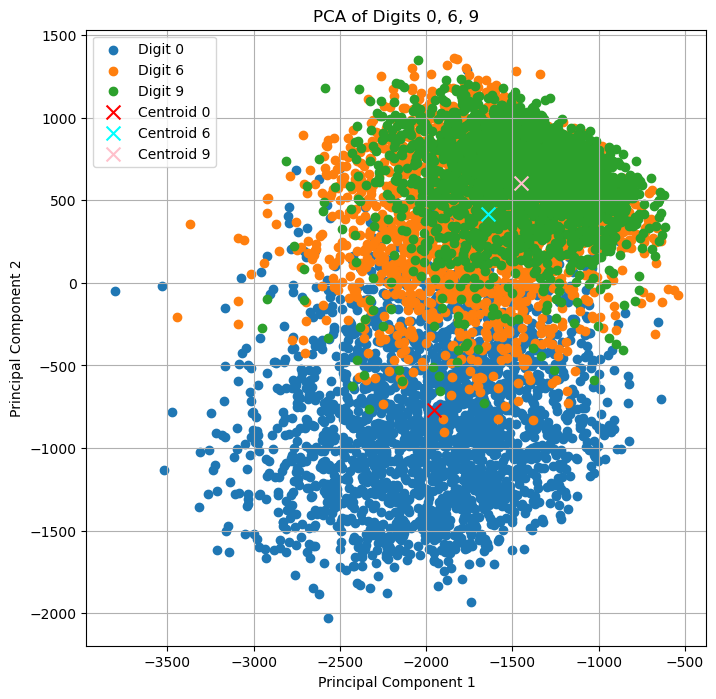

In [26]:
# 1.4 Compute PCA with k components
k = 2
U, S, Vt = svd(X_filt_train, full_matrices=False)
Uk = U[:, :k]

# Projection matrix
P = Uk.T

# Get the principal components of X by multiplying feature vectors (Uk) by the data matrix X
Z_filt_train = P @ X_filt_train

# Separate the projected data in the three classes and compute the centroids
Z1_filt_train = Z_filt_train[:, Y_filt_train == n1]
Z2_filt_train = Z_filt_train[:, Y_filt_train == n2]
Z3_filt_train = Z_filt_train[:, Y_filt_train == n3]

centroid1 = np.mean(Z1_filt_train, axis=1)
centroid2 = np.mean(Z2_filt_train, axis=1)
centroid3 = np.mean(Z3_filt_train, axis=1)

# Visualize the results and position of centroids of each cluster
plt.figure(figsize=(8, 8))
plt.scatter(Z1_filt_train[0, :], Z1_filt_train[1, :], label=f"Digit {n1}")
plt.scatter(Z2_filt_train[0, :], Z2_filt_train[1, :], label=f"Digit {n2}")
plt.scatter(Z3_filt_train[0, :], Z3_filt_train[1, :], label=f"Digit {n3}")
plt.scatter(centroid1[0], centroid1[1], s=100, marker='x', c='red', label=f"Centroid {n1}")
plt.scatter(centroid2[0], centroid2[1], s=100, marker='x', c='cyan', label=f"Centroid {n2}")
plt.scatter(centroid3[0], centroid3[1], s=100, marker='x', c='pink', label=f"Centroid {n3}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Digits 0, 6, 9")
plt.legend()
plt.grid()
plt.show()

In [27]:
# 1.5 For each cluster compute the average distance from its centroid
# The PCA property measured by this is the average distance from the centroid ???

Z1_c = Z1_filt_train - centroid1[:, np.newaxis]
Z2_c = Z2_filt_train - centroid2[:, np.newaxis]
Z3_c = Z3_filt_train - centroid3[:, np.newaxis]

Z1_c_mean = np.mean(np.linalg.norm(Z1_c, axis=0))
Z2_c_mean = np.mean(np.linalg.norm(Z2_c, axis=0))
Z3_c_mean = np.mean(np.linalg.norm(Z3_c, axis=0))

print(f"Average distance from centroid for class {n1}: {Z1_c_mean}")
print(f"Average distance from centroid for class {n2}: {Z2_c_mean}")
print(f"Average distance from centroid for class {n3}: {Z3_c_mean}")

Average distance from centroid for class 0: 639.2744796722856
Average distance from centroid for class 6: 514.720148629172
Average distance from centroid for class 9: 396.63762189330555


As we can see from the results and the previous plot, the more the average distance is higher, the more the points are spread across the diagram, in particular this measurement can help us evaluate how separable the classes are in the reduced-dimensional space.

In [28]:
# 1.6 Projecting the test set
Z_filt_test = P @ X_filt_test

# 1.7 Separate the projected data into the three classes and compute the average distance from the centroid
Z1_filt_test = Z_filt_test[:, Y_filt_test == n1]
Z2_filt_test = Z_filt_test[:, Y_filt_test == n2]
Z3_filt_test = Z_filt_test[:, Y_filt_test == n3]

centroid1_test = np.mean(Z1_filt_test, axis=1)
centroid2_test = np.mean(Z2_filt_test, axis=1)
centroid3_test = np.mean(Z3_filt_test, axis=1)

Z1_test_c = Z1_filt_test - centroid1_test[:, np.newaxis]
Z2_test_c = Z2_filt_test - centroid2_test[:, np.newaxis]
Z3_test_c = Z3_filt_test - centroid3_test[:, np.newaxis]

Z1_test_c_mean = np.mean(np.linalg.norm(Z1_test_c, axis=0))
Z2_test_c_mean = np.mean(np.linalg.norm(Z2_test_c, axis=0))
Z3_test_c_mean = np.mean(np.linalg.norm(Z3_test_c, axis=0))

print(f"Average distance from centroid for class {n1} in the test set: {Z1_test_c_mean}")
print(f"Average distance from centroid for class {n2} in the test set: {Z2_test_c_mean}")
print(f"Average distance from centroid for class {n3} in the test set: {Z3_test_c_mean}")

Average distance from centroid for class 0 in the test set: 657.8871884387321
Average distance from centroid for class 6 in the test set: 509.0792433729189
Average distance from centroid for class 9 in the test set: 397.29605314412794


From the results we can see how the average distance didn't change much, this tells us that the test samples have a distribution in the feature space that is statistically similar to the training samples

In [29]:
# 1.8 Define a classification algorithm
def classify_digit(x, centroids, nums):
    # Calculate distances from x to each centroid
    distances = np.linalg.norm(centroids - x[:, np.newaxis], axis=0)
    return nums[np.argmin(distances)]

# Ensure centroids are in the correct shape
centroids = np.array([centroid1, centroid2, centroid3]).T

# Classify each test sample and compute predictions
predictions = np.array([
    classify_digit(Z_filt_test[:, i], centroids, np.array([n1, n2, n3]))
    for i in range(Z_filt_test.shape[1])
])

# Compute the misclassification rate
misclassification_rate = np.mean(predictions != Y_filt_test)

print(f"Misclassification rate: {misclassification_rate}")

Misclassification rate: 0.3086203881797517


Distance 0: 387.4650298960312
Distance 6: 352.3662602629437
Distance 9: 289.02006858908845
Misclassification rate for k=1: 0.5182724252491694
Distance 0: 870.0740268565551
Distance 6: 700.4195600916389
Distance 9: 533.8043911682921
Misclassification rate for k=3: 0.20388179751704844
Distance 0: 1088.3648225428528
Distance 6: 871.3608513165766
Distance 9: 647.6623700800154
Misclassification rate for k=5: 0.049134464067144605
Distance 0: 1186.2443864428055
Distance 6: 1001.5799098744403
Distance 9: 823.8880432362555
Misclassification rate for k=7: 0.04581220493093198
Distance 0: 1272.7426677528863
Distance 6: 1073.8390145730614
Distance 9: 947.0304814138706
Misclassification rate for k=9: 0.04388879174680888
Distance 0: 1323.8261520730478
Distance 6: 1139.8739462154635
Distance 9: 1019.5724374235106
Misclassification rate for k=11: 0.043713936002797694
Distance 0: 1367.2002760107414
Distance 6: 1207.8148438598637
Distance 9: 1066.7150161870413
Misclassification rate for k=13: 0.043364224

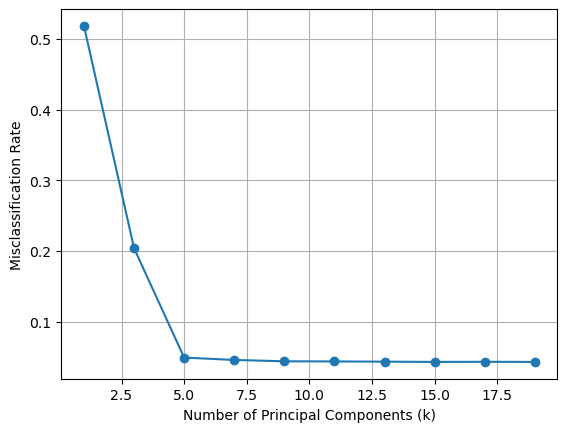

In [37]:
# 1.9 Repeat the experiment with different values of k
def experiment_with_k(k):
    U, S, Vt = svd(X_filt_train, full_matrices=False)
    
    # Select the first k principal components
    Uk = U[:, :k]
    P = Uk.T

    # Project training and test data
    Z_filt_train = P @ X_filt_train
    Z_filt_test = P @ X_filt_test

    # Separate training data by class
    Z1_filt_train = Z_filt_train[:, Y_filt_train == n1]
    Z2_filt_train = Z_filt_train[:, Y_filt_train == n2]
    Z3_filt_train = Z_filt_train[:, Y_filt_train == n3]

    # Compute centroids for each class in the training set
    centroid1 = np.mean(Z1_filt_train, axis=1)
    centroid2 = np.mean(Z2_filt_train, axis=1)
    centroid3 = np.mean(Z3_filt_train, axis=1)

    # Compute distances for each class in the test set
    Z1_filt_test = Z_filt_test[:, Y_filt_test == n1]
    Z2_filt_test = Z_filt_test[:, Y_filt_test == n2]
    Z3_filt_test = Z_filt_test[:, Y_filt_test == n3]

    distances1 = np.linalg.norm(Z1_filt_test - centroid1[:, None], axis=0)
    distances2 = np.linalg.norm(Z2_filt_test - centroid2[:, None], axis=0)
    distances3 = np.linalg.norm(Z3_filt_test - centroid3[:, None], axis=0)
    
    print(f"Distance 0: {np.mean(distances1)}")
    print(f"Distance 6: {np.mean(distances2)}")
    print(f"Distance 9: {np.mean(distances3)}")

    # Classify test samples using corrected classify_digit function
    centroids = np.array([centroid1, centroid2, centroid3]).T
    predictions = []
    
    for i in range(Z_filt_test.shape[1]):
        sample = Z_filt_test[:, i]
        distances = np.linalg.norm(sample.reshape((-1,1)) - centroids, axis=0)
        predicted_class = [n1, n2, n3][np.argmin(distances)]
        predictions.append(predicted_class)

    predictions = np.array(predictions)

    # Compute misclassification rate
    misclassification_rate = np.mean(predictions != Y_filt_test)
    
    print(f"Misclassification rate for k={k}: {misclassification_rate}")
    
    return misclassification_rate
    
misclassification_rates = []
for k in range(1, 20,2):
    misclassification_rates.append(experiment_with_k(k))
    
plt.plot(range(1, 20,2), misclassification_rates, marker='o')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Misclassification Rate")
plt.grid()
plt.show()